In [1]:
%load_ext autoreload
%autoreload 2
import networkx as nx

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="3"

import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.data import DataLoader
import argparse
import numpy as np
import random
import ogb
from ogb.graphproppred import PygGraphPropPredDataset, Evaluator
from graph_transformer import GT
from utils import pre_process, pre_process_with_summary, get_n_params, get_optimizer
import datetime
from tqdm import tqdm
from tensorboardX import SummaryWriter
import pytz

Data(adamic_edge_attr=[308, 1], alloc_edge_attr=[308, 1], cn_edge_attr=[308, 1], comm_edge_attr=[308, 1], edge_attr=[308, 3], edge_index=[2, 308], hier_label=[32, 4], hsd_edge_attr=[308, 4], jaccard_edge_attr=[308, 1], lap_x=[32, 10], orig_edge_attr=[70, 3], orig_edge_index=[2, 70], sd_edge_attr=[308, 1], x=[32, 9], y=[1, 1])
torch.Size([70, 3])
torch.Size([308, 3])
tensor([[0.0000],
        [0.0000],
        [0.5000],
        [0.0000],
        [0.2500],
        [0.0000],
        [0.2500],
        [0.2500],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.5000],
        [0.0000],
        [0.0000],
        [0.5000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.3333],
        [0.0000],
        [0.3333],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.5000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.5000],
 

In [2]:
parser = argparse.ArgumentParser(description='PyTorch implementation of relative positional encodings and relation-aware self-attention for graph Transformers')
args = parser.parse_args("")

args.dataset = 'ogbg-molhiv'
args.n_classes = 1
args.lr = 3e-4
args.n_hid = 512
args.n_heads = 8
args.n_layer = 4
args.dropout = 0.3
args.num_epochs = 50
args.k_hop_neighbors = 3
args.weight_decay = 1e-2
args.bsz      = 512
args.strategies = ['ea', 'sd']
args.summary_node = True
args.hier_levels = 3
args.lap_k = None
args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.metric = 'rocauc'
print("device:", args.device)

device: cuda


In [3]:
print("Loading data...")
print("dataset: {} ".format(args.dataset))
tz = pytz.timezone('US/Pacific')
time_now = datetime.datetime.now(tz).strftime('%m-%d_%H:%M:%S')

if args.summary_node:
    pre_transform = lambda d : pre_process_with_summary(d, args)
    root_path= f'dataset/{args.dataset}/with_summary_{args.k_hop_neighbors}'
    args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/with_summary_k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')

else:
    pre_transform = lambda d : pre_process(d, args)
    root_path= f'dataset/{args.dataset}/{args.k_hop_neighbors}'
    args.writer = SummaryWriter(log_dir=f'runs_new/{args.dataset}/k={args.k_hop_neighbors}/strats={"-".join(args.strategies)}/{time_now}')
    
    
dataset = PygGraphPropPredDataset(name=args.dataset, pre_transform=pre_transform, root = root_path)
evaluator = Evaluator(name=args.dataset)
split_idx = dataset.get_idx_split()
edge_dim_dict = {'ea': None, \
                 'disc': {
                     'sd': (dataset.data.sd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'cn': (dataset.data.cn_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
#                      'hsd': (dataset.data.hsd_edge_attr.max(dim=0)[0].int().view(-1) + 1).tolist(), \
                    },
                 'cont': {
                 }
                }
model = GT(args.n_hid, args.n_classes, args.n_heads, args.n_layer, edge_dim_dict, args.dropout, args.summary_node, args.lap_k).to(args.device)

Loading data...
dataset: ogbg-molhiv 


In [4]:
valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.bsz, shuffle = False)
test_loader  = DataLoader(dataset[split_idx["test"]],  batch_size=args.bsz, shuffle = False)

In [5]:
print('Model #Params: %d' % get_n_params(model))

criterion = torch.nn.BCEWithLogitsLoss(reduction = "mean")

optimizer = get_optimizer(model, weight_decay = args.weight_decay, learning_rate = args.lr)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 500, eta_min=1e-6)
scheduler.step(-500)

Model #Params: 7457281


/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/opt/conda/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git

In [7]:
import seaborn as sb
def mat_visualize(node_size, edge_index, edge_attr):
    mat = np.zeros((node_size, node_size))
    for e, v in zip(edge_index, edge_attr):
        mat[e[0]][e[1]] = v
    sb.heatmap(mat)

/opt/conda/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
def turn_prob(inp):
    prob = torch.sigmoid(inp)
    prob = torch.cat([prob, 1-prob], dim=1)
    return prob

In [9]:
train_mask = torch.zeros(len(dataset), dtype=bool)
valid_mask = torch.zeros(len(dataset), dtype=bool)
test_mask = torch.zeros(len(dataset), dtype=bool)

train_mask[split_idx["train"]] = True
valid_mask[split_idx["valid"]] = True
test_mask[split_idx["test"]] = True
def entropy_loss(pred, label):
    return torch.mean(torch.sum(-label * pred, dim=1))

In [10]:
stats = []
for epoch in range(args.num_epochs):
    model.train()
    train_loss = []
    train_adv  = []
    y_true = []
    y_scores = []
    all_idx = torch.randperm(len(dataset))
    for batch_idx in tqdm(range(len(all_idx) // args.bsz)):
        batch = all_idx[batch_idx * args.bsz : (batch_idx + 1) * args.bsz]
        train_msk = train_mask[batch]    
        data = Batch.from_data_list(dataset[batch])
        data.to(args.device)
        
        strats = {'ea': data.edge_attr,  'sd': data.sd_edge_attr}
        out = model(data.x, data.batch, data.edge_index, strats)
        with torch.no_grad():
            strats = {'ea': data.edge_attr,  'sd': data.sd_edge_attr}
            adv_out = model(data.x, data.batch, data.edge_index, strats)
        
        loss = criterion(out[train_msk], data.y[train_msk].float())
        adv_loss = entropy_loss(turn_prob(out).log(), turn_prob(adv_out))
        (loss + 0.5 * adv_loss).backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
        train_loss += [loss.item()]
        train_adv  += [adv_loss.item()]
        
        y_true += [data.y]
        y_scores += [out]

    input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
    train_metric = evaluator.eval(input_dict)[args.metric]
    

    model.eval()
    with torch.no_grad():
        valid_loss = []
        y_true = []
        y_scores = []
        for num_iters, data in enumerate(tqdm(valid_loader)):
            data.to(args.device)
            strats = {'ea': data.edge_attr, 'sd': data.sd_edge_attr}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            valid_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        valid_metric = evaluator.eval(input_dict)[args.metric]
        
        test_loss = []
        y_true = []
        y_scores = []
        for data in test_loader:
            data.to(args.device)
            strats = {'ea': data.edge_attr, 'sd': data.sd_edge_attr}
            out = model(data.x, data.batch, data.edge_index, strats)
        
            loss = criterion(out, data.y.float())
            test_loss += [loss.item()]

            y_true += [data.y]
            y_scores += [out]

        input_dict = {"y_true": torch.cat(y_true), "y_pred": torch.cat(y_scores)}
        test_metric = evaluator.eval(input_dict)[args.metric]

    print('Epoch %d: LR: %.5f, Train loss: %.3f Train %s: %.3f Train Adv: %.3f Valid loss: %.3f  Valid %s: %.3f \
        Test loss: %.3f  Test %s: %.3f' \
          % (epoch + 1, optimizer.param_groups[0]['lr'], np.average(train_loss), args.metric, train_metric, \
             np.average(train_adv), np.average(valid_loss), args.metric, valid_metric, \
             np.average(test_loss), args.metric, test_metric))
    stats += [[epoch, np.average(train_loss), train_metric, np.average(valid_loss), valid_metric, np.average(test_loss), test_metric]]

  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 1: LR: 0.00002, Train loss: 0.276 Train rocauc: 0.487 Train Adv: 0.387 Valid loss: 0.092  Valid rocauc: 0.547         Test loss: 0.142  Test rocauc: 0.511


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 2: LR: 0.00007, Train loss: 0.163 Train rocauc: 0.485 Train Adv: 0.159 Valid loss: 0.088  Valid rocauc: 0.629         Test loss: 0.133  Test rocauc: 0.634


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 3: LR: 0.00014, Train loss: 0.161 Train rocauc: 0.538 Train Adv: 0.163 Valid loss: 0.086  Valid rocauc: 0.656         Test loss: 0.132  Test rocauc: 0.664


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 4: LR: 0.00021, Train loss: 0.158 Train rocauc: 0.591 Train Adv: 0.156 Valid loss: 0.090  Valid rocauc: 0.650         Test loss: 0.120  Test rocauc: 0.687


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 5: LR: 0.00027, Train loss: 0.150 Train rocauc: 0.684 Train Adv: 0.150 Valid loss: 0.078  Valid rocauc: 0.739         Test loss: 0.114  Test rocauc: 0.717


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 6: LR: 0.00030, Train loss: 0.144 Train rocauc: 0.719 Train Adv: 0.145 Valid loss: 0.078  Valid rocauc: 0.768         Test loss: 0.111  Test rocauc: 0.739


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 7: LR: 0.00029, Train loss: 0.138 Train rocauc: 0.738 Train Adv: 0.142 Valid loss: 0.076  Valid rocauc: 0.787         Test loss: 0.110  Test rocauc: 0.747


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 8: LR: 0.00025, Train loss: 0.135 Train rocauc: 0.751 Train Adv: 0.138 Valid loss: 0.082  Valid rocauc: 0.778         Test loss: 0.113  Test rocauc: 0.760


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 9: LR: 0.00018, Train loss: 0.132 Train rocauc: 0.764 Train Adv: 0.137 Valid loss: 0.076  Valid rocauc: 0.789         Test loss: 0.107  Test rocauc: 0.764


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 10: LR: 0.00010, Train loss: 0.129 Train rocauc: 0.768 Train Adv: 0.133 Valid loss: 0.075  Valid rocauc: 0.785         Test loss: 0.108  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 11: LR: 0.00004, Train loss: 0.126 Train rocauc: 0.781 Train Adv: 0.134 Valid loss: 0.073  Valid rocauc: 0.784         Test loss: 0.107  Test rocauc: 0.773


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 12: LR: 0.00001, Train loss: 0.124 Train rocauc: 0.790 Train Adv: 0.127 Valid loss: 0.073  Valid rocauc: 0.786         Test loss: 0.107  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 13: LR: 0.00001, Train loss: 0.123 Train rocauc: 0.791 Train Adv: 0.132 Valid loss: 0.072  Valid rocauc: 0.786         Test loss: 0.107  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 14: LR: 0.00004, Train loss: 0.125 Train rocauc: 0.788 Train Adv: 0.131 Valid loss: 0.070  Valid rocauc: 0.787         Test loss: 0.105  Test rocauc: 0.772


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 15: LR: 0.00010, Train loss: 0.124 Train rocauc: 0.789 Train Adv: 0.127 Valid loss: 0.072  Valid rocauc: 0.784         Test loss: 0.106  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 16: LR: 0.00018, Train loss: 0.124 Train rocauc: 0.784 Train Adv: 0.131 Valid loss: 0.078  Valid rocauc: 0.785         Test loss: 0.113  Test rocauc: 0.769


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 17: LR: 0.00025, Train loss: 0.124 Train rocauc: 0.796 Train Adv: 0.128 Valid loss: 0.070  Valid rocauc: 0.789         Test loss: 0.109  Test rocauc: 0.739


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 18: LR: 0.00029, Train loss: 0.125 Train rocauc: 0.781 Train Adv: 0.130 Valid loss: 0.070  Valid rocauc: 0.782         Test loss: 0.104  Test rocauc: 0.770


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 19: LR: 0.00030, Train loss: 0.124 Train rocauc: 0.782 Train Adv: 0.131 Valid loss: 0.076  Valid rocauc: 0.781         Test loss: 0.110  Test rocauc: 0.759


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 20: LR: 0.00027, Train loss: 0.123 Train rocauc: 0.793 Train Adv: 0.130 Valid loss: 0.068  Valid rocauc: 0.794         Test loss: 0.103  Test rocauc: 0.763


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 21: LR: 0.00021, Train loss: 0.120 Train rocauc: 0.799 Train Adv: 0.128 Valid loss: 0.076  Valid rocauc: 0.765         Test loss: 0.109  Test rocauc: 0.768


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 22: LR: 0.00014, Train loss: 0.118 Train rocauc: 0.808 Train Adv: 0.125 Valid loss: 0.072  Valid rocauc: 0.799         Test loss: 0.106  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 23: LR: 0.00007, Train loss: 0.114 Train rocauc: 0.817 Train Adv: 0.126 Valid loss: 0.071  Valid rocauc: 0.790         Test loss: 0.105  Test rocauc: 0.773


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 24: LR: 0.00002, Train loss: 0.112 Train rocauc: 0.824 Train Adv: 0.120 Valid loss: 0.073  Valid rocauc: 0.787         Test loss: 0.109  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 25: LR: 0.00000, Train loss: 0.111 Train rocauc: 0.824 Train Adv: 0.122 Valid loss: 0.071  Valid rocauc: 0.786         Test loss: 0.107  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 26: LR: 0.00002, Train loss: 0.110 Train rocauc: 0.831 Train Adv: 0.121 Valid loss: 0.072  Valid rocauc: 0.784         Test loss: 0.107  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 27: LR: 0.00007, Train loss: 0.111 Train rocauc: 0.826 Train Adv: 0.120 Valid loss: 0.072  Valid rocauc: 0.776         Test loss: 0.106  Test rocauc: 0.771


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 28: LR: 0.00014, Train loss: 0.112 Train rocauc: 0.823 Train Adv: 0.120 Valid loss: 0.071  Valid rocauc: 0.789         Test loss: 0.105  Test rocauc: 0.772


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 29: LR: 0.00021, Train loss: 0.114 Train rocauc: 0.818 Train Adv: 0.124 Valid loss: 0.072  Valid rocauc: 0.791         Test loss: 0.107  Test rocauc: 0.769


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 30: LR: 0.00027, Train loss: 0.115 Train rocauc: 0.815 Train Adv: 0.122 Valid loss: 0.077  Valid rocauc: 0.812         Test loss: 0.113  Test rocauc: 0.768


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 31: LR: 0.00030, Train loss: 0.116 Train rocauc: 0.810 Train Adv: 0.125 Valid loss: 0.066  Valid rocauc: 0.824         Test loss: 0.107  Test rocauc: 0.766


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 32: LR: 0.00029, Train loss: 0.116 Train rocauc: 0.810 Train Adv: 0.126 Valid loss: 0.070  Valid rocauc: 0.811         Test loss: 0.108  Test rocauc: 0.772


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 33: LR: 0.00025, Train loss: 0.114 Train rocauc: 0.821 Train Adv: 0.124 Valid loss: 0.068  Valid rocauc: 0.813         Test loss: 0.113  Test rocauc: 0.779


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 34: LR: 0.00018, Train loss: 0.112 Train rocauc: 0.826 Train Adv: 0.121 Valid loss: 0.073  Valid rocauc: 0.788         Test loss: 0.110  Test rocauc: 0.759


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 35: LR: 0.00010, Train loss: 0.109 Train rocauc: 0.831 Train Adv: 0.119 Valid loss: 0.070  Valid rocauc: 0.810         Test loss: 0.108  Test rocauc: 0.780


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 36: LR: 0.00004, Train loss: 0.106 Train rocauc: 0.844 Train Adv: 0.118 Valid loss: 0.069  Valid rocauc: 0.794         Test loss: 0.106  Test rocauc: 0.774


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 37: LR: 0.00001, Train loss: 0.104 Train rocauc: 0.851 Train Adv: 0.114 Valid loss: 0.070  Valid rocauc: 0.793         Test loss: 0.107  Test rocauc: 0.774


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 38: LR: 0.00001, Train loss: 0.103 Train rocauc: 0.847 Train Adv: 0.118 Valid loss: 0.070  Valid rocauc: 0.794         Test loss: 0.107  Test rocauc: 0.774


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 39: LR: 0.00004, Train loss: 0.104 Train rocauc: 0.849 Train Adv: 0.116 Valid loss: 0.070  Valid rocauc: 0.797         Test loss: 0.108  Test rocauc: 0.773


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 40: LR: 0.00010, Train loss: 0.105 Train rocauc: 0.843 Train Adv: 0.116 Valid loss: 0.072  Valid rocauc: 0.797         Test loss: 0.110  Test rocauc: 0.772


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 41: LR: 0.00018, Train loss: 0.106 Train rocauc: 0.841 Train Adv: 0.116 Valid loss: 0.075  Valid rocauc: 0.810         Test loss: 0.115  Test rocauc: 0.774


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 42: LR: 0.00025, Train loss: 0.111 Train rocauc: 0.831 Train Adv: 0.121 Valid loss: 0.071  Valid rocauc: 0.818         Test loss: 0.109  Test rocauc: 0.763


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 43: LR: 0.00029, Train loss: 0.110 Train rocauc: 0.829 Train Adv: 0.121 Valid loss: 0.067  Valid rocauc: 0.817         Test loss: 0.112  Test rocauc: 0.760


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 44: LR: 0.00030, Train loss: 0.109 Train rocauc: 0.839 Train Adv: 0.120 Valid loss: 0.073  Valid rocauc: 0.822         Test loss: 0.114  Test rocauc: 0.781


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 45: LR: 0.00027, Train loss: 0.110 Train rocauc: 0.836 Train Adv: 0.121 Valid loss: 0.071  Valid rocauc: 0.807         Test loss: 0.112  Test rocauc: 0.765


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 46: LR: 0.00021, Train loss: 0.108 Train rocauc: 0.835 Train Adv: 0.120 Valid loss: 0.069  Valid rocauc: 0.822         Test loss: 0.111  Test rocauc: 0.758


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 47: LR: 0.00014, Train loss: 0.105 Train rocauc: 0.849 Train Adv: 0.117 Valid loss: 0.065  Valid rocauc: 0.823         Test loss: 0.107  Test rocauc: 0.773


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 48: LR: 0.00007, Train loss: 0.103 Train rocauc: 0.860 Train Adv: 0.115 Valid loss: 0.067  Valid rocauc: 0.831         Test loss: 0.108  Test rocauc: 0.781


  0%|          | 0/80 [00:00<?, ?it/s]

Epoch 49: LR: 0.00002, Train loss: 0.099 Train rocauc: 0.862 Train Adv: 0.110 Valid loss: 0.067  Valid rocauc: 0.836         Test loss: 0.109  Test rocauc: 0.772


100%|██████████| 9/9 [00:03<00:00,  2.49it/s]


Epoch 50: LR: 0.00000, Train loss: 0.098 Train rocauc: 0.869 Train Adv: 0.111 Valid loss: 0.066  Valid rocauc: 0.833         Test loss: 0.108  Test rocauc: 0.770


[48.          0.09930257  0.86182452  0.06670468  0.83583493  0.10888646
  0.77172599]


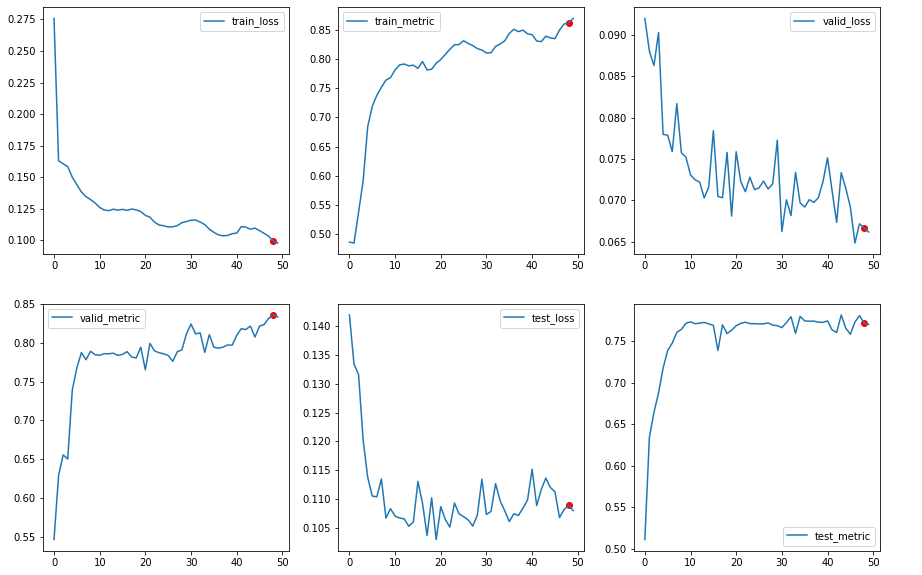

In [11]:
import matplotlib.pyplot as plt
labels = ['epoch', 'train_loss', 'train_metric', 'valid_loss', 'valid_metric', 'test_loss', 'test_metric']
fig = plt.figure(figsize=(15, 10))
stats_np = np.array(stats)
best_valid = stats_np[stats_np[:50, 4].argmax()]
print(best_valid)
for i in range(1, stats_np.shape[-1]):
    ax = fig.add_subplot(2, 3, i)
    ax.plot(stats_np[:, i], label=labels[i])
    ax.scatter(x=best_valid[0], y=best_valid[i], color='red')
    ax.annotate(best_valid[i].round(3), xy=(best_valid[0]+5, best_valid[i]), color='red')
    ax.legend()
